In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
from braket.aws import AwsDevice
from braket.devices import Devices
from braket.jobs import hybrid_job, save_job_result
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import BackendEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP

from qiskit_braket_provider import BraketProvider

sv1 = AwsDevice(Devices.Amazon.SV1)
image_uri2 = "011528273261.dkr.ecr.eu-west-2.amazonaws.com/amazon-braket-inhibitq-qiskit:latest"


In [2]:
@hybrid_job(device=sv1.arn, include_modules="qiskit_algorithms", image_uri=image_uri2)
def main():
    """Decorated function that will be run in the docker container."""
    backend = BraketProvider().get_backend("SV1")

    h2_op = SparsePauliOp(
        ["II", "IZ", "ZI", "ZZ", "XX"],
        coeffs=[
            -1.052373245772859,
            0.39793742484318045,
            -0.39793742484318045,
            -0.01128010425623538,
            0.18093119978423156,
        ],
    )

    estimator = BackendEstimator(backend=backend, options={"shots": 10})
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    slsqp = SLSQP(maxiter=1)

    vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=slsqp)

    vqe_result = vqe.compute_minimum_eigenvalue(h2_op)

    # Save the results of the VQE computation.
    save_job_result(
        {
            "VQE": {
                "eigenvalue": vqe_result.eigenvalue.real,
                "optimal_parameters": list(vqe_result.optimal_parameters.values()),
                "optimal_point": vqe_result.optimal_point.tolist(),
                "optimal_value": vqe_result.optimal_value.real,
            }
        }
    )

Skipping python version validation, make sure versions match between local environment and container.


In [3]:
job = main()

In [4]:
result = job.result()
pprint(result)

{'VQE': {'eigenvalue': -1.0686123342327907,
         'optimal_parameters': [-3.6458725741727207,
                                4.8025533455745855,
                                -0.8805902794478939,
                                1.1092716884820648,
                                5.488336786309688,
                                -5.539796834227313,
                                0.4817179108345888,
                                6.148251125541766],
         'optimal_point': [-3.6458725741727207,
                           4.8025533455745855,
                           -0.8805902794478939,
                           1.1092716884820648,
                           5.488336786309688,
                           -5.539796834227313,
                           0.4817179108345888,
                           6.148251125541766],
         'optimal_value': -1.0686123342327907}}


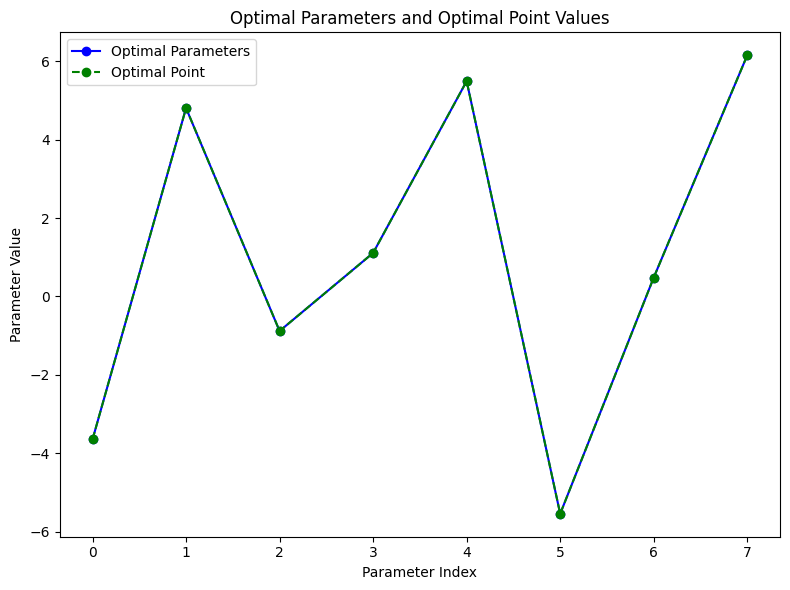

In [5]:
# Extract data for visualization
optimal_parameters = result["VQE"]["optimal_parameters"]
optimal_point = result["VQE"]["optimal_point"]

# Create a single plot for both sets of data
plt.figure(figsize=(8, 6))

# Plot Optimal Parameters
plt.plot(
    optimal_parameters, marker="o", linestyle="-", color="b", label="Optimal Parameters"
)

# Plot Optimal Point Values
plt.plot(optimal_point, marker="o", linestyle="--", color="g", label="Optimal Point")

# Set labels and title
plt.xlabel("Parameter Index")
plt.ylabel("Parameter Value")
plt.title("Optimal Parameters and Optimal Point Values")

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
